In [4]:
# !pip install catboost
# !pip install sklearn.kernel.ridge 

In [5]:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor

from sklearn.decomposition import PCA



In [6]:
data = pd.read_csv('kl_property_pricing_dataSet.csv')

In [7]:
data

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished
...,...,...,...,...,...,...,...,...
53878,"Bangsar, Kuala Lumpur","RM 5,100,000",5+1,4.0,NaN,Bungalow (Corner),Land area : 7168 sq. ft.,Fully Furnished
53879,"Bangsar, Kuala Lumpur","RM 5,000,000",5,4.0,NaN,Bungalow (Intermediate),Land area : 15000 sq. ft.,Unfurnished
53880,"Bangsar, Kuala Lumpur","RM 5,500,000",5+1,4.0,NaN,Bungalow (Intermediate),Land area : 7168 sq. ft.,Partly Furnished
53881,"Wangsa Maju, Kuala Lumpur","RM 480,000",3,2.0,NaN,Condominium (Intermediate),"Built-up : 1,150 sq. ft.",Unfurnished


Preprocessing the data:

Before building predictive models, the dataset undergoes preprocessing steps:

Handling Missing Values: Null values are dropped from the dataset.
Cleaning Columns:
The 'Price' column is cleaned by removing 'RM' and ',' characters to convert it into a float value.
The 'Furnishing' column is converted into dummy variables.
The 'Size' column is split into separate columns for size and built type, and then converted into numeric values.
The 'Property Type' column is converted into dummy variables.
The 'Rooms' column is cleaned by removing trailing '+' characters and converting to numeric values.
The 'Location' column is converted to lowercase and unnecessary substrings are removed.then we converte it into dummy variables.

Here we can see that we have a lot of null values

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53883 entries, 0 to 53882
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       53883 non-null  object 
 1   Price          53635 non-null  object 
 2   Rooms          52177 non-null  object 
 3   Bathrooms      51870 non-null  float64
 4   Car Parks      36316 non-null  float64
 5   Property Type  53858 non-null  object 
 6   Size           52820 non-null  object 
 7   Furnishing     46953 non-null  object 
dtypes: float64(2), object(6)
memory usage: 3.3+ MB


Drop all null values

In [9]:
data.dropna(inplace=True)

After droping all null values now we dont have any missing column or null column

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31899 entries, 0 to 53882
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       31899 non-null  object 
 1   Price          31899 non-null  object 
 2   Rooms          31899 non-null  object 
 3   Bathrooms      31899 non-null  float64
 4   Car Parks      31899 non-null  float64
 5   Property Type  31899 non-null  object 
 6   Size           31899 non-null  object 
 7   Furnishing     31899 non-null  object 
dtypes: float64(2), object(6)
memory usage: 2.2+ MB


clean the 'Price' column : The 'Price' column is cleaned by removing 'RM' and ',' characters to convert it into a float value.

'Price' column before cleaning

In [11]:
data['Price']

0        RM 1,250,000
2        RM 1,030,000
4          RM 900,000
5        RM 5,350,000
7        RM 2,600,000
             ...     
53862      RM 750,000
53868    RM 1,400,000
53869      RM 880,000
53876    RM 2,700,000
53882      RM 540,000
Name: Price, Length: 31899, dtype: object

In [12]:
data['Price'] = [float(price.replace('RM ', '').replace(',', '')) for price in data['Price']]


Price column after cleaning

In [13]:
data['Price']

0        1250000.0
2        1030000.0
4         900000.0
5        5350000.0
7        2600000.0
           ...    
53862     750000.0
53868    1400000.0
53869     880000.0
53876    2700000.0
53882     540000.0
Name: Price, Length: 31899, dtype: float64

clean the 'furnishing' column : The 'Furnishing' column is converted into dummy variables.

'furnishing' column before cleaning

In [14]:
data['Furnishing']

0         Fully Furnished
2        Partly Furnished
4        Partly Furnished
5        Partly Furnished
7        Partly Furnished
               ...       
53862    Partly Furnished
53868     Fully Furnished
53869    Partly Furnished
53876    Partly Furnished
53882    Partly Furnished
Name: Furnishing, Length: 31899, dtype: object

here we can see all the possible values for the 'Furnishing' column

In [15]:
data['Furnishing'].value_counts()

Furnishing
Partly Furnished    18093
Fully Furnished      9844
Unfurnished          3775
Unknown               187
Name: count, dtype: int64

what we are going to do is that we are going to convert each value into a column

In [16]:
data = data.join(pd.get_dummies(data.Furnishing)).drop(['Furnishing'], axis=1)

clean the 'size' column : The 'Size' column is split into separate columns for size and built type, and then converted into numeric values.

'size' column before cleaning

In [17]:
data['Size']

0        Built-up : 1,335 sq. ft.
2        Built-up : 1,875 sq. ft.
4        Built-up : 1,513 sq. ft.
5        Land area : 7200 sq. ft.
7        Land area : 3600 sq. ft.
                   ...           
53862      Built-up : 915 sq. ft.
53868    Land area : 1544 sq. ft.
53869      Built-up : 650 sq. ft.
53876    Built-up : 3,973 sq. ft.
53882    Built-up : 1,313 sq. ft.
Name: Size, Length: 31899, dtype: object

we are going to split the 'size' column into two columns. one for the size it self and the other for the built type (to specify wether its built-up or land area) 

In [18]:
# Define the function to split Size into an array of two different values
def split_property_size(size, tp=0):
    try:
        return size.split(":")[tp].strip()
    except AttributeError:
        return size


def convert_built_size_numeric(bsize):
    try:
        if re.search(r"sq\.*\s*ft\.*", bsize) is None:
            return None
        bsize = bsize.replace(",", "")  # Remove the commas in size
        bsize = bsize.replace("'", "")  # Remove the apostrophes in size
        bsize = bsize.replace("sq. ft.", "")  # Remove the 'sq. ft.' from size
        bsize = bsize.replace("sf", "")  # Remove 'sf' format
        if '*' in bsize:
            bsize.split('*')
            return int(bsize[0]) * int(bsize[1])
        if 'x' in bsize:
            bsize.split('x')
            return int(bsize[0]) * int(bsize[1])
        bsize = bsize.strip().lower()  # Strip and convert to lowercase
        return int(bsize)
    except:
        return None


In [19]:
# Create a new column with the built-up type
data["Built_Type"] = data['Size'].astype(str).apply(split_property_size, tp=0)

# Create a new column with built-up size
data["Built_Size"] = data['Size'].apply(split_property_size, tp=1)

# Convert built-up size into numeric value
data['Built_Size'] = data['Built_Size'].apply(convert_built_size_numeric)

# Delete the 'Size' column
del data['Size']

In [20]:
data = data.join(pd.get_dummies(data.Built_Type)).drop(['Built_Type'], axis=1)

clean the 'Property Type' column : The 'Property Type' column is converted into dummy variables.

In [21]:
data = data.join(pd.get_dummies(data['Property Type'])).drop(['Property Type'], axis=1)

clean 'Rooms' Column : The 'Rooms' column is cleaned by removing trailing '+' characters and converting to numeric values.


In [22]:
def clean_trailing_plus(rooms):
    if rooms.endswith("+"):
        return str(int(rooms[:-1]))  # Remove the last character i.e. '+'
    if '+' in rooms:
        xx = rooms.split("+")  # Split the string on '+' sign
        return str(int(xx[0]) + int(xx[1]))  # Add both sides of the string
    if 'Studio' in rooms:
        return '1'  # Studio flats are generally single-roomed
    if '20 Above' in rooms:
        return '20'  # Assume '20 Above' is rated at 20 since the number is only 8 units, we can safely assume this
    if rooms == '':
        return '0'
    else:
        return rooms  # Return the number of rooms if nothing above matches


In [23]:
data['Rooms'] = data['Rooms'].astype(str).apply(clean_trailing_plus)  # Apply cleaning operation
data['Rooms'] = pd.to_numeric(data['Rooms'])

clean the 'Location' column : The 'Location' column is converted to lowercase and unnecessary substrings are removed.then we converte it into dummy variables.

In [24]:
data['Location'] = data['Location'].str.lower() # convert all the cities to lower case
data['Location'] = data['Location'].str.replace(", kuala lumpur", "") # remove ', kuala lumpur
data = data.join(pd.get_dummies(data['Location'])).drop(['Location'], axis=1)

In [25]:
data.dropna(inplace=True)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31554 entries, 0 to 53882
Columns: 180 entries, Price to wangsa maju
dtypes: bool(175), float64(4), int64(1)
memory usage: 6.7 MB


data after preprocessing

In [27]:
data

,Price,Rooms,Bathrooms,Car Parks,Fully Furnished,Partly Furnished,Unfurnished,Unknown,Built_Size,Built-up,...,sunway spk,taman desa,taman duta,taman ibukota,taman melawati,taman tar,taman tun dr ismail,"taman yarl, uog",titiwangsa,wangsa maju
0,1250000.0,3,3.0,2.0,True,False,False,False,1335.0,True,...,False,False,False,False,False,False,False,False,False,False
2,1030000.0,3,4.0,2.0,False,True,False,False,1875.0,True,...,False,False,False,False,False,False,False,False,False,False
4,900000.0,5,3.0,2.0,False,True,False,False,1513.0,True,...,False,False,False,False,False,False,False,False,False,False
5,5350000.0,6,5.0,4.0,False,True,False,False,7200.0,False,...,False,False,False,False,False,False,True,False,False,False
7,2600000.0,5,4.0,4.0,False,True,False,False,3600.0,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53862,750000.0,3,2.0,1.0,False,True,False,False,915.0,True,...,False,False,False,False,False,False,False,False,False,False
53868,1400000.0,4,3.0,2.0,True,False,False,False,1544.0,False,...,False,False,False,False,False,False,False,False,False,False
53869,880000.0,1,1.0,1.0,False,True,False,False,650.0,True,...,False,False,False,False,False,False,False,False,False,False
53876,2700000.0,6,6.0,3.0,False,True,False,False,3973.0,True,...,False,False,False,False,False,False,False,False,False,False


In [28]:
from sklearn.preprocessing import StandardScaler
y = data['Price']
X = data.drop(['Price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now we are going to test multiple models predicting the property pricing.

Models :

Several machine learning models are applied to predict property prices:

1. Linear Regression
2. Random Forest Regressor
3. XGBoost Regressor
4. Ridge Regression
5. Voting Regressor
6. Stacking Regressor

GridSearchCV is used for hyperparameter tuning. Model performance is evaluated using the R-squared score.

First lets try the LinearRegression model

In [29]:
lr = LinearRegression()

In [30]:
lr.fit(X_train, y_train)

LinearRegression()

In [31]:
lr.score(X_test, y_test)

0.27966108192262384

In [32]:
y_predicted = lr.predict(X_test)

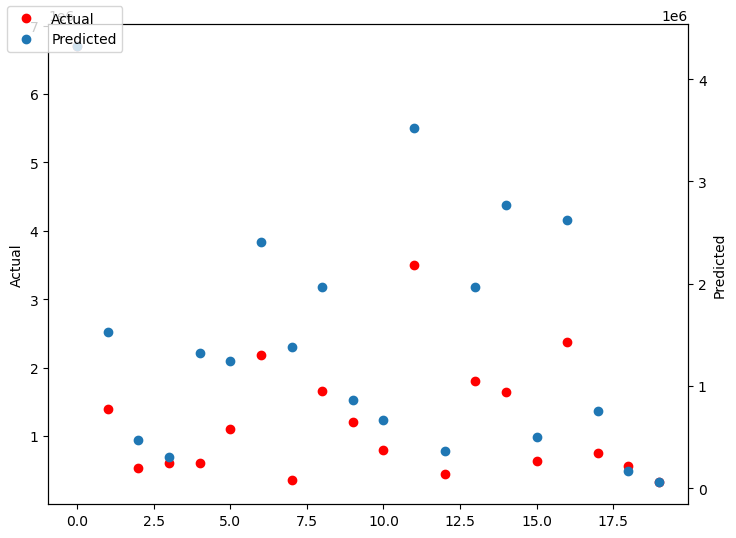

In [33]:
    fig = plt.figure()
    a1 = fig.add_axes([0,0,1,1])
    x = range(20)
    a1.plot(x,y_test[:20], 'ro')
    a1.set_ylabel('Actual')
    a2 = a1.twinx()
    a2.plot(x, y_predicted[:20],'o')
    a2.set_ylabel('Predicted')
    fig.legend(labels = ('Actual','Predicted'),loc='upper left')
    plt.show()

we can see that LinearRegression model performed really bad now lets try the RandomForestRegressor model.
Keep in mind that all the below models will take some time to fit the data in.

In [34]:
RFR = RandomForestRegressor(random_state=13)

In [35]:
param_grid_RFR = {
    'max_depth' : [5,10,15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3,5,10]
}

In [36]:
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, n_jobs=-1)

In [37]:
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=13), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 250, 500]})

In [38]:
rfr_cv.score(X_train, y_train)

0.9134413418250183

In [39]:
rfr_cv.best_params_

{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 500}

In [40]:
y_predicted = rfr_cv.predict(X_test)

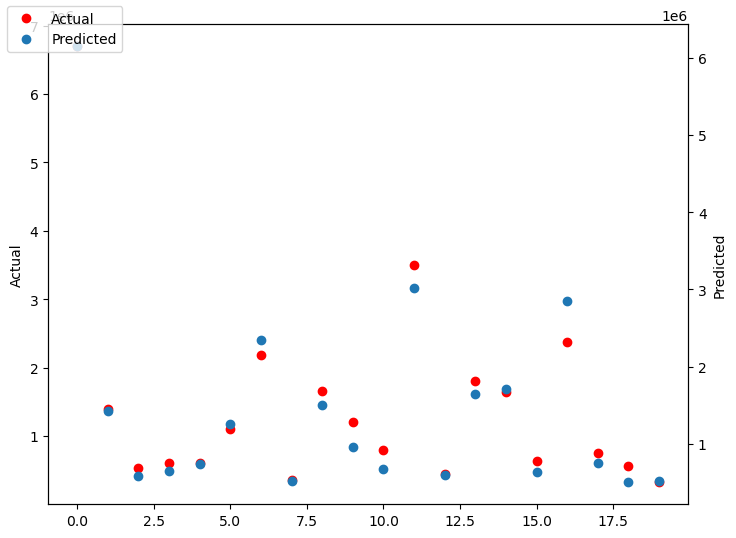

In [41]:
    fig = plt.figure()
    a1 = fig.add_axes([0,0,1,1])
    x = range(20)
    a1.plot(x,y_test[:20], 'ro')
    a1.set_ylabel('Actual')
    a2 = a1.twinx()
    a2.plot(x, y_predicted[:20],'o')
    a2.set_ylabel('Predicted')
    fig.legend(labels = ('Actual','Predicted'),loc='upper left')
    plt.show()

RandomForestRegressor model performed really well. now lets try the XGBRegressor model

In [42]:
XGB = XGBRegressor(random_state=13)

In [43]:
param_grid_XGB = {
    'learning_rate':[0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight':[1,2,3],
    'gamma': [0,0.1,0.2],
    'subsample':[0.8, 0.9, 1.0],
    'colsample_bytree': [0.8,0.9,1.0],
}

In [44]:
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, n_jobs=-1)

In [45]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=13, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [300],
                         'subsample': [0.8, 0.9, 1.0]})

In [46]:
xgb_cv.score(X_test, y_test)

0.8322576420780349

In [47]:
y_predicted = xgb_cv.predict(X_test)

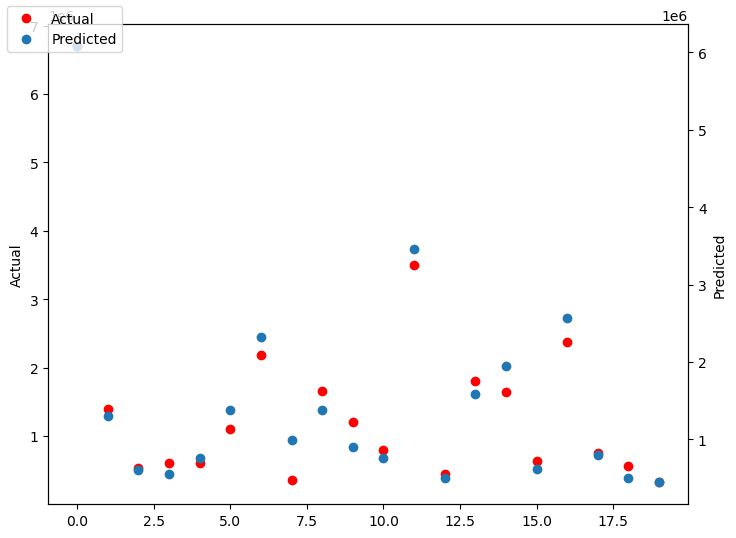

In [48]:
    fig = plt.figure()
    a1 = fig.add_axes([0,0,1,1])
    x = range(20)
    a1.plot(x,y_test[:20], 'ro')
    a1.set_ylabel('Actual')
    a2 = a1.twinx()
    a2.plot(x, y_predicted[:20],'o')
    a2.set_ylabel('Predicted')
    fig.legend(labels = ('Actual','Predicted'),loc='upper left')
    plt.show()

we can see that XGBRegressor model performed good but not better than RandomForestRegressor model. now lets try the Ridge model

In [49]:
ridge = Ridge()

In [50]:
param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

In [51]:
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, n_jobs=-1)

In [52]:
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag']})

In [53]:
ridge_cv.score(X_test, y_test)

0.6638922572950139

In [54]:
y_predicted = ridge_cv.predict(X_test)

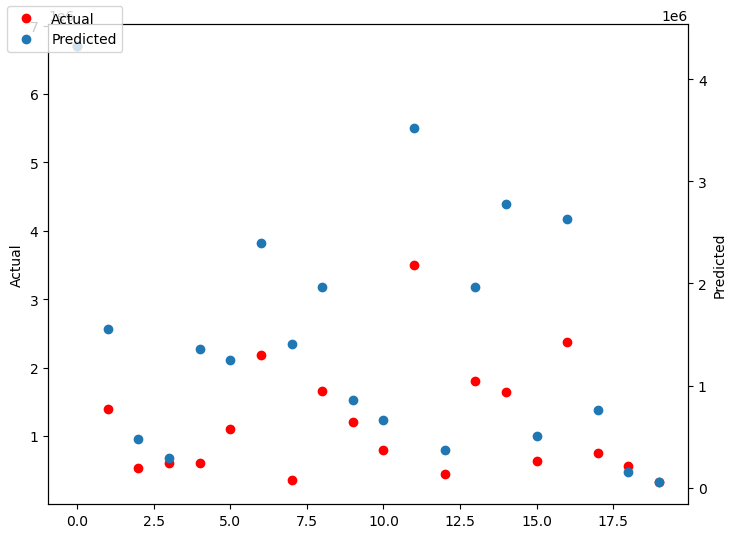

In [55]:
    fig = plt.figure()
    a1 = fig.add_axes([0,0,1,1])
    x = range(20)
    a1.plot(x,y_test[:20], 'ro')
    a1.set_ylabel('Actual')
    a2 = a1.twinx()
    a2.plot(x, y_predicted[:20],'o')
    a2.set_ylabel('Predicted')
    fig.legend(labels = ('Actual','Predicted'),loc='upper left')
    plt.show()

Ridge model performed bad but better than the LinearRegression model. now lets try the VotingRegressor model

In [56]:
vr = VotingRegressor([('xgb', xgb_cv.best_estimator_),
                     ('ridge', ridge_cv.best_estimator_)],
                     weights=[2,1])

In [57]:
vr.fit(X_train, y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=1.0, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.2, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None, min_child_weight=3,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=13, ...)),
                            ('ridge', Ridge(alpha=3, solver='svd'))],
                weights=[2, 1])

In [58]:
vr.score(X_test, y_test)

0.8105586582660236

In [59]:
y_predicted = vr.predict(X_test)

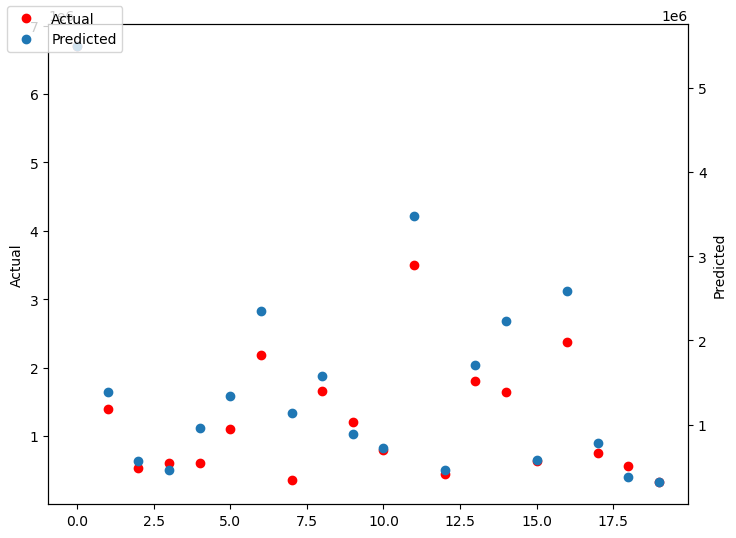

In [60]:
    fig = plt.figure()
    a1 = fig.add_axes([0,0,1,1])
    x = range(20)
    a1.plot(x,y_test[:20], 'ro')
    a1.set_ylabel('Actual')
    a2 = a1.twinx()
    a2.plot(x, y_predicted[:20],'o')
    a2.set_ylabel('Predicted')
    fig.legend(labels = ('Actual','Predicted'),loc='upper left')
    plt.show()

VotingRegressor model performed pretty well but not as good as the XGBRegressor and RandomForestRegressor models. now lets try the StackingRegressor model 

In [61]:
estimators = [
    ('xgb', xgb_cv.best_estimator_),
    ('rfr', rfr_cv.best_estimator_),
]

In [62]:
stackreg = StackingRegressor(
    estimators = estimators,
    final_estimator = vr
)

In [63]:
stackreg.fit(X_train, y_train)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0...
                                                                            interaction_constraints=None,
                                                                            learning_rate=0.2,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=3,
                                                                            max_leaves=None,
                                                                            min_child_weight=3,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=300,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=13, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=3,
                                                                     solver='svd'))],
                                                  weights=[2, 1]))

In [64]:
stackreg.score(X_test, y_test)

0.8500741340935227

In [65]:
y_predicted = stackreg.predict(X_test)

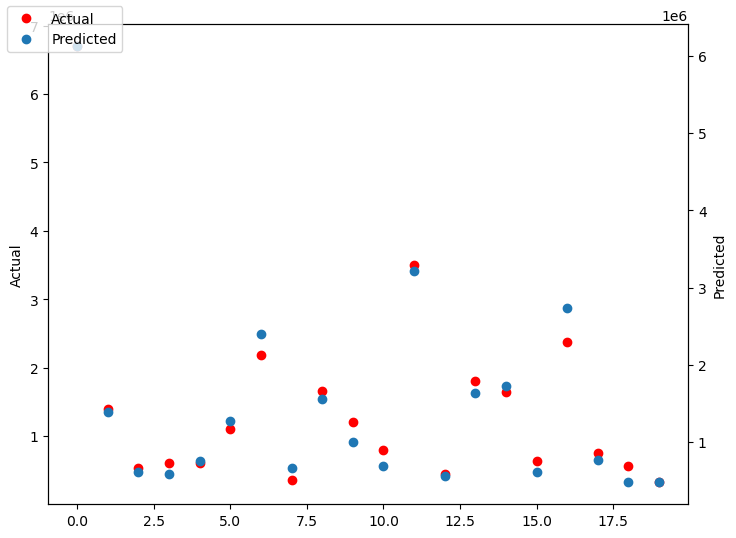

In [66]:
    fig = plt.figure()
    a1 = fig.add_axes([0,0,1,1])
    x = range(20)
    a1.plot(x,y_test[:20], 'ro')
    a1.set_ylabel('Actual')
    a2 = a1.twinx()
    a2.plot(x, y_predicted[:20],'o')
    a2.set_ylabel('Predicted')
    fig.legend(labels = ('Actual','Predicted'),loc='upper left')
    plt.show()

Dimensionality Reduction

Principal Component Analysis (PCA) is applied to the dataset to reduce dimensionality while preserving 95% of the variance. Random Forest Regressor is then applied to the reduced dataset. Although the performance slightly decreases, the model's speed improves significantly due to dimensionality reduction.

after comparing all models, we can see that RandomForestRegressor peformed the best. now lets try to apply pca to our data and run randomForestRegressor again and see how its going to perform

In [67]:
from sklearn.decomposition import PCA
pca=PCA(0.95)
X_pca = pca.fit_transform(X)
X_pca.shape


(31554, 1)

In [68]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=30)

In [69]:
RFR = RandomForestRegressor(random_state=13)

In [70]:
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, n_jobs=-1)

In [71]:
rfr_cv.fit(X_train_pca, y_train_pca)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=13), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 250, 500]})

In [72]:
rfr_cv.score(X_test_pca, y_test_pca)

0.7463267860748277

In [73]:
y_predicted = rfr_cv.predict(X_test_pca)

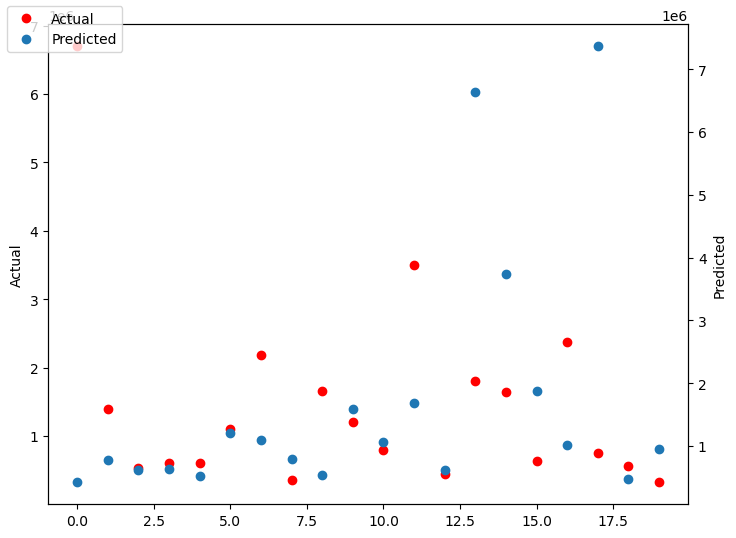

In [74]:
    fig = plt.figure()
    a1 = fig.add_axes([0,0,1,1])
    x = range(20)
    a1.plot(x,y_test[:20], 'ro')
    a1.set_ylabel('Actual')
    a2 = a1.twinx()
    a2.plot(x, y_predicted[:20],'o')
    a2.set_ylabel('Predicted')
    fig.legend(labels = ('Actual','Predicted'),loc='upper left')
    plt.show()

although when we applied PCA we got worse result but the model was much faster due to dimensionality reduction

Comparasion and evaluation:

Results:

Linear Regression: Poor performance observed.
Random Forest Regressor: Best performance among individual models.
XGBoost Regressor: Good performance but slightly worse than Random Forest.
Ridge Regression: Performance similar to Linear Regression.
Voting Regressor: Poor performance but better than Linear Regression model.
Stacking Regressor: Performs well slightly better than the XGBoost Regressor.

Justification:

Predictions from these models are invaluable in real estate for pricing decisions, optimizing marketing, assessing risk, financial planning, and enhancing customer experience. They enable informed decisions, mitigate risks, and provide insights into market trends, ultimately leading to better outcomes for buyers, sellers, developers, and investors.

Recommendation on Implementations

Pricing Decisions: Use the best-performing model (Random Forest) to accurately predict property prices, aiding sellers in setting competitive prices and buyers in evaluating investments.

Marketing Optimization: Identify key property features driving prices through model analysis, allowing for targeted marketing strategies to attract buyers.

Risk Assessment: Analyze model predictions against actual sales data to identify areas of overvaluation or undervaluation, guiding investment decisions towards more stable properties.

Financial Planning: Utilize model predictions to estimate investment returns and assess property affordability, informing budgeting and mortgage planning.

Decision-Making: Incorporate model insights into decision-making processes for developers, investors, and individuals to prioritize investment opportunities effectively.

Customer Experience Enhancement: Offer personalized property recommendations based on model predictions to enhance the customer experience and improve client satisfaction.